In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
pd.options.mode.chained_assignment = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd

# Update the path below based on where the file is located in your Google Drive
file_path = '/content/drive/My Drive/Reviews.tsv'

# Load the TSV file using the file_path variable
df = pd.read_csv(file_path, delimiter='\t')

# Display the first few rows of the DataFrame
print(df.head())


Mounted at /content/drive
                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [ ]:
# Check if each row in the Sentiment column is a string
string_rows = df['Liked'].apply(lambda x: isinstance(x, str))
# Filter out rows where Sentiment is a string
cleaned_data = df[~string_rows]
df['Liked'] = pd.to_numeric(df['Liked'], errors='coerce')

# Optional: Handle NaN values. Here's an example of dropping them
df.dropna(subset=['Liked'], inplace=True)

In [ ]:
print(df['Liked'].unique())


[1 0]


In [ ]:
# Applying the mapping to check manually
test_mapping = df['Liked'].apply(lambda x: 'positive' if x ==1 else 'negative')
print(test_mapping.value_counts())


Liked
positive    500
negative    500
Name: count, dtype: int64


In [ ]:
pip install nlpaug


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.word as naw
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to augment data
def augment_text(data, augmenter, repetitions=1):
    augmented_texts = []
    for text in data:
        # Ensure text is a string
        text = str(text)
        for _ in range(repetitions):
            augmented = augmenter.augment(text)
            augmented_texts.append(str(augmented))  # Ensure the augmented text is a string
    return augmented_texts

# Assuming df is already loaded and contains the columns 'Review' and 'Liked'
# Split your data
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Liked'], test_size=0.2, random_state=42)

# Initialize augmenter - here using synonym replacement
augmenter = naw.SynonymAug(aug_src='wordnet')

# Augment data - now tripling the data
augmented_texts = augment_text(X_train, augmenter, repetitions=3)  # Tripling data with augmentation

# Reset index for y_train to properly repeat it
y_train_reset = y_train.reset_index(drop=True)

# Extend the original training data with augmented data
augmented_data = pd.DataFrame({'Review': augmented_texts, 'Liked': y_train_reset.repeat(3).values})  # Repeat y_train three times
X_train_augmented = pd.concat([X_train, augmented_data['Review']]).reset_index(drop=True)
y_train_augmented = pd.concat([y_train, augmented_data['Liked']]).reset_index(drop=True)

# Verification that all entries are strings
if any(not isinstance(x, str) for x in X_train_augmented):
    print("Non-string elements detected in augmented data.")

assert all(isinstance(x, str) for x in X_train_augmented), "All elements in X_train_augmented must be strings."

# Now you have a significantly augmented dataset
print("Original training data size:", len(X_train))
print("Augmented training data size:", len(X_train_augmented))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Original training data size: 800
Augmented training data size: 3200


In [ ]:
import nltk
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import nlpaug.augmenter.word as naw
import pandas as pd

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace "n't" with "not" to handle cases like "isn't"
    text = re.sub(r"n't", " not", text)
    # Handle negations by appending "_not" to the following word
    text = re.sub(r"\b(not)\s+(\w+)\b", r"\1_\2", text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text).strip()
    return text

# Function to augment data
def augment_text(data, augmenter, repetitions=1):
    augmented_texts = []
    for text in data:
        # Ensure text is a string
        text = str(text)
        for _ in range(repetitions):
            augmented = augmenter.augment(text)
            augmented_texts.append(str(augmented))  # Ensure the augmented text is a string
    return augmented_texts

# Load dataset
# Replace 'Review' with the appropriate column name containing the text data
df['Review'] = df['Review'].apply(preprocess_text)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Liked'], test_size=0.2, random_state=42)

# Initialize augmenter - here using synonym replacement
augmenter = naw.SynonymAug(aug_src='wordnet')

# Augment data - now tripling the data
augmented_texts = augment_text(X_train, augmenter, repetitions=3)  # Tripling data with augmentation

# Reset index for y_train to properly repeat it
y_train_reset = y_train.reset_index(drop=True)

# Extend the original training data with augmented data
augmented_data = pd.DataFrame({'Review': augmented_texts, 'Liked': y_train_reset.repeat(3).values})  # Repeat y_train three times
X_train_augmented = pd.concat([X_train, augmented_data['Review']]).reset_index(drop=True)
y_train_augmented = pd.concat([y_train, augmented_data['Liked']]).reset_index(drop=True)

# Verification that all entries are strings
if any(not isinstance(x, str) for x in X_train_augmented):
    print("Non-string elements detected in augmented data.")

assert all(isinstance(x, str) for x in X_train_augmented), "All elements in X_train_augmented must be strings."

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train_augmented)
X_test_vectorized = vectorizer.transform(X_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print("Dimensions of X_train_vectorized:", X_train_vectorized.shape)
print("Dimensions of y_train:", len(y_train))

Dimensions of X_train_vectorized: (3200, 3448)
Dimensions of y_train: 800


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from xgboost import XGBClassifier

class AdvancedStackingSentiment:
    def __init__(self):
        # Define text preprocessing pipeline
        self.vectorizer = TfidfVectorizer(stop_words='english')

        # Define base models with their respective pipelines without vectorizers
        base_models = [
            ('naive_bayes', make_pipeline_imblearn(
                SMOTE(),
                MultinomialNB(alpha=0.1)
            )),
            ('svm', make_pipeline_imblearn(
                SMOTE(),
                SVC(probability=True, kernel='linear', C=1)
            )),
            ('log_reg', make_pipeline_imblearn(
                SMOTE(),
                LogisticRegression(C=1)
            )),
            ('xgboost', make_pipeline_imblearn(
                SMOTE(),
                XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
            ))
        ]

        # Define the final estimator
        final_estimator = LogisticRegression()

        # Define the stacking classifier with cross-validation
        self.pipeline = StackingClassifier(
            estimators=base_models,
            final_estimator=final_estimator
        )

    def fit(self, X_train, y_train):
        # Transform the training data using the vectorizer
        X_train_vectorized = self.vectorizer.fit_transform(X_train)
        self.pipeline.fit(X_train_vectorized, y_train)

    def evaluate(self, X, y, cv=5):
        # Transform the input data using the vectorizer
        X_vectorized = self.vectorizer.transform(X)

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        accuracies = []
        f1_scores = []
        recalls = []
        for train_index, test_index in skf.split(X_vectorized, y):
            X_train_fold, X_test_fold = X_vectorized[train_index], X_vectorized[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            self.pipeline.fit(X_train_fold, y_train_fold)
            y_pred_fold = self.pipeline.predict(X_test_fold)

            accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
            f1_scores.append(f1_score(y_test_fold, y_pred_fold))
            recalls.append(recall_score(y_test_fold, y_pred_fold))

        return accuracies, f1_scores, recalls

    def predict_text(self, text):
        # Transform the input text using the vectorizer
        text_vectorized = self.vectorizer.transform([text])
        return self.pipeline.predict(text_vectorized)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    stacking_sentiment = AdvancedStackingSentiment()

    # Fit the model
    stacking_sentiment.fit(X_train_augmented, y_train_augmented)

    # Evaluate the model using cross-validation
    accuracies, f1_scores, recalls = stacking_sentiment.evaluate(X_train_augmented, y_train_augmented)

    # Print average metrics
    print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.2f}")
    print(f"Average F1 Score: {sum(f1_scores) / len(f1_scores):.2f}")
    print(f"Average Recall: {sum(recalls) / len(recalls):.2f}")

    # Predict sentiment for a new text
    new_text = "It was good"
    prediction = stacking_sentiment.predict_text(new_text)
    print(f"Sentiment prediction for the new text: {prediction}")


Average Accuracy: 0.94
Average F1 Score: 0.93
Average Recall: 0.92
Sentiment prediction for the new text: [1]


In [ ]:
pip install joblib


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from xgboost import XGBClassifier
import joblib
import os

class AdvancedStackingSentiment:
    def __init__(self):
        # Define text preprocessing pipeline
        self.vectorizer = TfidfVectorizer(stop_words='english')

        # Define base models with their respective pipelines without vectorizers
        base_models = [
            ('naive_bayes', make_pipeline_imblearn(
                SMOTE(),
                MultinomialNB(alpha=0.1)
            )),
            ('svm', make_pipeline_imblearn(
                SMOTE(),
                SVC(probability=True, kernel='linear', C=1)
            )),
            ('log_reg', make_pipeline_imblearn(
                SMOTE(),
                LogisticRegression(C=1)
            )),
            ('xgboost', make_pipeline_imblearn(
                SMOTE(),
                XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
            ))
        ]

        # Define the final estimator
        final_estimator = LogisticRegression()

        # Define the stacking classifier with cross-validation
        self.pipeline = StackingClassifier(
            estimators=base_models,
            final_estimator=final_estimator
        )

    def fit(self, X_train, y_train):
        # Transform the training data using the vectorizer
        X_train_vectorized = self.vectorizer.fit_transform(X_train)
        self.pipeline.fit(X_train_vectorized, y_train)

    def evaluate(self, X, y, cv=5):
        # Transform the input data using the vectorizer
        X_vectorized = self.vectorizer.transform(X)

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        accuracies = []
        f1_scores = []
        recalls = []
        for train_index, test_index in skf.split(X_vectorized, y):
            X_train_fold, X_test_fold = X_vectorized[train_index], X_vectorized[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            self.pipeline.fit(X_train_fold, y_train_fold)
            y_pred_fold = self.pipeline.predict(X_test_fold)

            accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
            f1_scores.append(f1_score(y_test_fold, y_pred_fold))
            recalls.append(recall_score(y_test_fold, y_pred_fold))

        return accuracies, f1_scores, recalls

    def predict_text(self, text):
        # Transform the input text using the vectorizer
        text_preprocessed = preprocess_text(text)
    # Transform the preprocessed text using the vectorizer
        text_vectorized = self.vectorizer.transform([text_preprocessed])
    # Predict the sentiment
        prediction = self.pipeline.predict(text_vectorized)
        return prediction

    def predict_proba_text(self, text):
        # Preprocess and transform the input text using the vectorizer
        text_preprocessed = preprocess_text(text)
        text_vectorized = self.vectorizer.transform([text_preprocessed])
        # Predict the probability of each class
        prediction_proba = self.pipeline.predict_proba(text_vectorized)
        return prediction_proba

    def save_model(self, model_path):
        # Save the pipeline and vectorizer
        joblib.dump((self.pipeline, self.vectorizer), model_path)

    def load_model(self, model_path):
        # Load the pipeline and vectorizer
        self.pipeline, self.vectorizer = joblib.load(model_path)

# Example usage
if __name__ == "__main__":
    # Initialize the model
    stacking_sentiment = AdvancedStackingSentiment()

    # Fit the model
    stacking_sentiment.fit(X_train_augmented, y_train_augmented)

    # Evaluate the model using cross-validation
    accuracies, f1_scores, recalls = stacking_sentiment.evaluate(X_train_augmented, y_train_augmented)

    # Print average metrics
    print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.2f}")
    print(f"Average F1 Score: {sum(f1_scores) / len(f1_scores):.2f}")
    print(f"Average Recall: {sum(recalls) / len(recalls):.2f}")

    model_path = 'stacking_sentiment_model.joblib'
    stacking_sentiment.save_model(model_path)
    print(f"Model saved to {model_path}")

    # Load the model from the file
    loaded_model = AdvancedStackingSentiment()
    loaded_model.load_model(model_path)
    print(f"Model loaded from {model_path}")

    # Predict sentiment for a new text
    new_text = "It was good"
    prediction = loaded_model.predict_text(new_text)
    print(f"Sentiment prediction for the new text: {prediction}")
    prediction_proba = loaded_model.predict_proba_text(new_text)
    print(f"Sentiment prediction probability for the new text: {prediction_proba}")


Average Accuracy: 0.95
Average F1 Score: 0.95
Average Recall: 0.95
Model saved to stacking_sentiment_model.joblib
Model loaded from stacking_sentiment_model.joblib
Sentiment prediction for the new text: [1]
Sentiment prediction probability for the new text: [[0.03265007 0.96734993]]


In [ ]:
new_text = "you did all of it but make some changes"
prediction = stacking_sentiment.predict_text(new_text)
print(f"Sentiment prediction for the new text: {prediction}")

Sentiment prediction for the new text: [0]


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


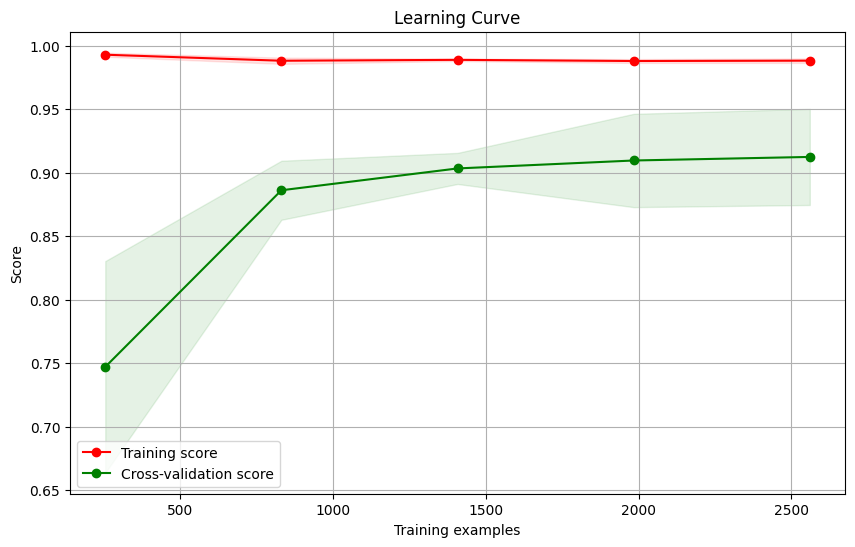

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5):
    """
    Generate a simple plot of the learning curve.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Example usage
plot_learning_curve(stacking_sentiment.pipeline, X_train_vectorized, y_train_augmented)
